# Classformer: Transformers for multivariate timeseries classification
This notebook is part of the bachelor's thesis *"Classformer: Transformers for multivariate timeseries classification"* [Bührer 2023] conducted at the [Chair for Mathematical Information Science (MINS)](https://www.mins.ee.ethz.ch/index.html) at ETH Zürich. The model is able to classify timeseries with the following characteristics:
 - Multivariate: More than one input variable,revered to as dimensions
 - Multiscale: Important features at multiple scales of time
 - Variable-Length: Series length can vary
 - Cross Dependencies: relevant features are at single/multiple timesteps at multiple/single dimension
 - Time-shift invariance: The events are not depedent on the absolute time but on the distance between timesteps.
 - Noise: Unwanted modifications introduced to the series
 - Class Imbalance: Distribution of observations across the known classes is biased or skewed

 
The model is able to handle all those characteristics of timeseries and furthermore has especcialy following properties.
 - Handling Seasonality and Trends
 - Adaptability to Concept Drift
 - Interpretable Output
 - Stability & reproducability

The notebook is structured as a tutorial.<br> 

<details>
  <summary markdown="span">Contact Info</summary>
  
Simon J. Bührer 2023<br>
[sbuehrer@student.ethz.ch](mailto:sbuehrer@student.ethz.ch)

</details>


## Setup
Importing the relevant libaries from .venv

In [2]:
# Libaries for math operations and plotting
import numpy as np 
import matplotlib.pyplot as plt

from scipy import signal
import networkx as nx
import random
from sklearn.model_selection import KFold 

# Libaries for machine learning tools
import tensorflow as tf 
 # Code for not using CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Libary for UAE dataset
from aeon.datasets import load_classification

# Libary for time handling
import time

# define Colors from ETH corporate design
ETH_Blau = '#215CAF'
ETH_Petrol = '#007894'
ETH_Bronze =  '#8E6713'
ETH_Rot = '#B7352D'
ETH_Purpur = '#A7117A'
ETH_Grau = '#6F6F6F'

2024-01-04 11:35:36.262350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data handling
This section loads the datasets from the [UEA multivariate time series classification archive](http://www.timeseriesclassification.com/)
The following 30 multivariate time series are available.
| Problem                   | TrainSize | TestSize | NumDimensions | SeriesLength | NumClasses | Normalised | Padded | MissingValues | ClassCounts |
|---------------------------|-----------|----------|---------------|--------------|------------|------------|--------|---------------|-------------|
| ArticularyWordRecognition | 275       | 300      | 9             | 144          | 25         | true       | false  | false         | 11          |
| AtrialFibrillation        | 15        | 15       | 2             | 640          | 3          | false      | false  | false         | 5           |
| BasicMotions              | 40        | 40       | 6             | 100          | 4          | false      | false  | false         | 10          |
| CharacterTrajectories     | 1422      | 1436     | 3             | 182          | 20         | false      | false  | false         | 85          |
| Cricket                   | 108       | 72       | 6             | 1197         | 12         | true       | false  | false         | 9           |
| DuckDuckGeese             | 50        | 50       | 1345          | 270          | 5          | false      | false  | false         | 10          |
| EigenWorms                | 128       | 131      | 6             | 17984        | 5          | false      | false  | false         | 55          |
| Epilepsy                  | 137       | 138      | 3             | 206          | 4          | false      | false  | false         | 34          |
| EthanolConcentration      | 261       | 263      | 3             | 1751         | 4          | false      | false  | false         | 65          |
| ERing                     | 30        | 270      | 4             | 65           | 6          | false      | false  | false         | 5           |
| FaceDetection             | 5890      | 3524     | 144           | 62           | 2          | false      | false  | false         | 2945        |
| FingerMovements           | 316       | 100      | 28            | 50           | 2          | false      | false  | false         | 159         |
| HandMovementDirection     | 160       | 74       | 10            | 400          | 4          | false      | false  | false         | 40          |
| Handwriting               | 150       | 850      | 3             | 152          | 26         | true       | false  | false         | 8           |
| Heartbeat                 | 204       | 205      | 61            | 405          | 2          | false      | false  | false         | 57          |
| InsectWingbeat            | 30000     | 20000    | 200           | 30           | 10         | false      | false  | false         | 3000        |
| JapaneseVowels            | 270       | 370      | 12            | 29           | 9          | false      | false  | false         | 30          |
| Libras                    | 180       | 180      | 2             | 45           | 15         | false      | false  | false         | 12          |
| LSST                      | 2459      | 2466     | 6             | 36           | 14         | false      | false  | false         | 34          |
| MotorImagery              | 278       | 100      | 64            | 3000         | 2          | false      | false  | false         | 139         |
| NATOPS                    | 180       | 180      | 24            | 51           | 6          | false      | false  | false         | 30          |
| PenDigits                 | 7494      | 3498     | 2             | 8            | 10         | false      | false  | false         | 780         |
| PEMS-SF                   | 267       | 173      | 963           | 144          | 7          | false      | false  | false         | 32          |
| Phoneme                   | 3315      | 3353     | 11            | 217          | 39         | false      | false  | false         | 85          |
| RacketSports              | 151       | 152      | 6             | 30           | 4          | false      | false  | false         | 39          |
| SelfRegulationSCP1        | 268       | 293      | 6             | 896          | 2          | false      | false  | false         | 135         |
| SelfRegulationSCP2        | 200       | 180      | 7             | 1152         | 2          | false      | false  | false         | 100         |
| SpokenArabicDigits        | 6599      | 2199     | 13            | 93           | 10         | false      | false  | false         | 660         |
| StandWalkJump             | 12        | 15       | 4             | 2500         | 3          | false      | false  | false         | 4           |
| UWaveGestureLibrary       | 120       | 320      | 3             | 315          | 8          | true       | false  | false         | 15          |

UEA provides data, reference results and links to code for Time Series Classification. Take a look into [The great multivariate time series classification bake off: a review and experimental evaluation of recent algorithmic advances](https://link.springer.com/article/10.1007/s10618-020-00727-3) for deeper understanding of the datasets.

In [3]:
# Padding function for unequal length
def pad_dataset(x,maxlen):
    y=[]
    for observation in x:
        temp=[]
        for series in observation:
            temp.append(np.pad(series, (0,maxlen-len(series)), 'symmetric'))
        y.append(temp)
    return np.array(y)

# Import a dataset (in this case "Epilepsy") and split it into inputs X and labels/outouts y
dataset_name='Epilepsy'
X_train, y_train, meta_data = load_classification(dataset_name,split="train",return_metadata=True)
X_test, y_test = load_classification(dataset_name,split="test",return_metadata=False)

# Handle dataset with unequal length
if(not meta_data["equallength"]):
   maxlen=max(max([max(map(len, observation)) for observation in X_train]),max([max(map(len, observation)) for observation in X_test]))
   X_train=pad_dataset(X_train,maxlen)
   X_test=pad_dataset(X_test,maxlen)

print(" Shape of inputs = ", X_train.shape)
print(" Shape of ouputs = ", y_train.shape)
print(" Meta data = ", meta_data)

 Shape of inputs =  (137, 3, 206)
 Shape of ouputs =  (137,)
 Meta data =  {'problemname': 'epilepsy', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['epilepsy', 'walking', 'running', 'sawing']}


### Test the Dataset
All datasets from UEA follow the same structure. <code> X = (N,D,T) </code> and <code> y = (N,) </code> Or in mathematical terms
$X \in \mathbb{R}^{(N \times D \times T)},Y \in c^{N}, c\in \mathbb{Z} \cap [0,C]$, where $N$ is the total number of train observation, $D$ the number of dimensions, $T$ the timeseries length and $C$ the number of Classes.

Here is a plot function that allows a simple visualization of the data

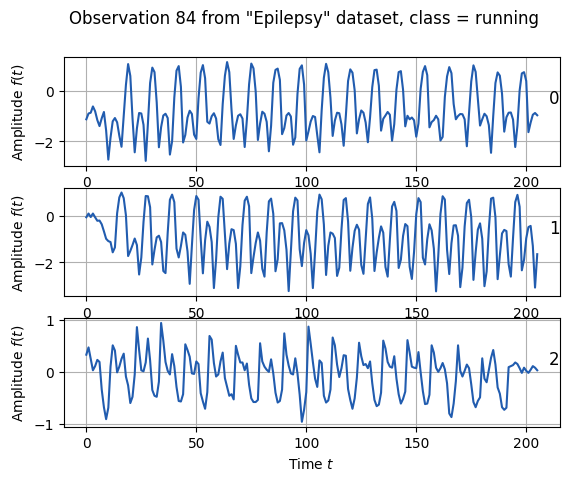

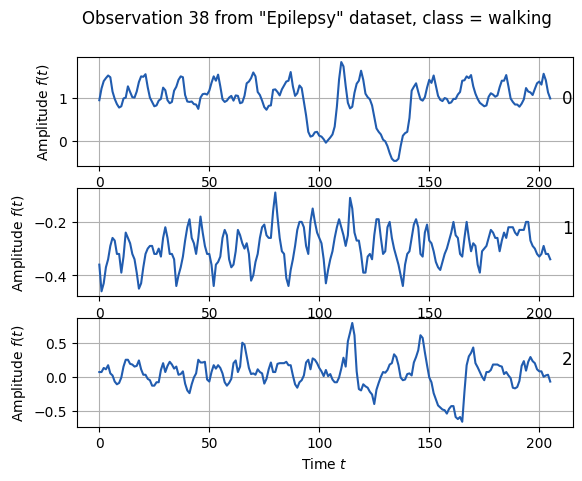

In [4]:
# Function which takes random samples and plots all dimesions along its time axis
def plt_sample(x,y,num_samples):
    idx=random.sample(range(len(x)), num_samples)
    for id in idx:
        samp=x[id]
        idd=random.sample(range(samp.shape[0]), 3)
        for num,dim in enumerate(sorted(idd)):
            ax=plt.subplot(3, 1, num+1)
            plt.plot(samp[dim], label=num,color=ETH_Blau)
            plt.title(dim, y=0.5, loc='right')
            plt.grid()
            ax.set_xlabel("Time $t$")
            ax.set_ylabel("Amplitude $f(t)$")
        plt.suptitle("Observation {} from \"{}\" dataset, class = {}".format(id,dataset_name,y[id]))
        plt.show()

# Plot two samples
plt_sample(X_train,y_train,2)

Categorical one hot encoding for the labels

In [5]:
integer_mapping = {x: i for i,x in enumerate(meta_data["class_values"])}
vec_train = [integer_mapping[word] for word in y_train]
vec_test = [integer_mapping[word] for word in y_test]
output_encoder = tf.keras.layers.CategoryEncoding(
          num_tokens=len(meta_data["class_values"]), output_mode="one_hot")

labels_train=output_encoder(vec_train)
labels_test=output_encoder(vec_test)

print("Inputs Shape: {}".format(X_train.shape))
print("Labels Shape: {}".format(labels_train.shape))

Inputs Shape: (137, 3, 206)
Labels Shape: (137, 4)


2024-01-04 11:35:39.203235: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-01-04 11:35:39.203271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: narigpu01
2024-01-04 11:35:39.203278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: narigpu01
2024-01-04 11:35:39.203477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.199.2
2024-01-04 11:35:39.203503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.199.2
2024-01-04 11:35:39.203509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 470.199.2


## Define the components
In the upcoming sections, we'll break down the components that make up the final model.

### Wavelet Transform
Often times relevant information is hidden in the frequency domain of a timeseries. There are multiple ways to implement these e.g. add the discret fourier transformation (DFT) to the timeseries or create a seperate encoder tower, similar to the ["Gated Transformer Networks"](https://arxiv.org/abs/2103.14438) and gate them. However in this thesis we are using the Wavelet transform as proposed by ["Transformers for EEG classification"](https://dial.uclouvain.be/memoire/ucl/object/thesis:40381) and ["FEDformer: Frequency Enhanced Decomposed Transformer for Long-term Series Forecasting"](https://arxiv.org/abs/2201.12740). We are using the continuous Wavelet transform with a Morlet wavelet (see plot below) to transform the timeseries $X$ into scalograms $X_{scal}$.<br>
<img src="src/figures/dpw.png" width="300">

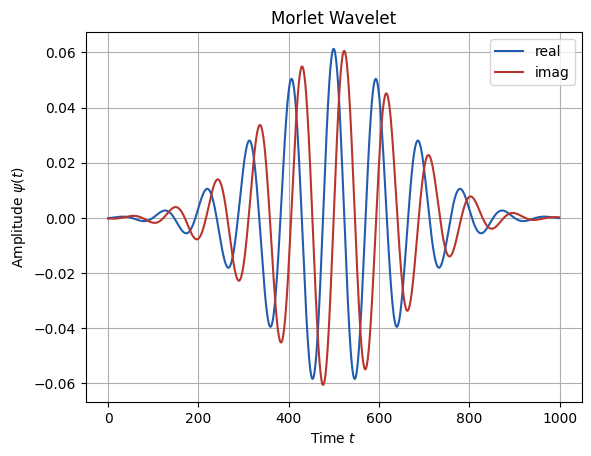

In [6]:
# Plot the Morlet Wavelet with Omega 10
M,s,w = 1000,150.0,10.0
wavelet = signal.morlet2(M, s, w)
plt.plot(wavelet.real, label="real",color=ETH_Blau)
plt.plot(wavelet.imag, label="imag",color=ETH_Rot)
plt.legend()
plt.grid()
plt.xlabel("Time $t$")
plt.ylabel("Amplitude $\psi(t)$")
plt.title("Morlet Wavelet")
plt.show()

The Morlet wavelet is defined by $\psi(x) = exp(\frac{j\cdot w \cdot x}{s}) \cdot exp(-\frac{1}{2}\cdot(\frac{x}{s})^2) \cdot \pi^{-\frac{1}{4}} \cdot \sqrt{\frac{1}{s}}$<br>
The Wavelet transform is implemented in a tensorflow layer. Since the transform returns a complex array we compute the absolute value to get a real representation. An other often used option is to multiply the result by its complex conjugate and get a power representation of the Wavelet transform. After this layer the timeseries length $T$ stays the same, but an additional axis is created for the frequency domain. The frequeny dimension size <code>freq_size </code> or $F=2^z,z\in \mathbb{N}$ can be choosen arbitarily, but is conviniently chosen to be a power of 2 to reduce padding in the DPW layer.

In [7]:
class WaveletTransform(tf.keras.layers.Layer):
  def __init__(self, freq_size=64):
    super().__init__()
    self.freq_size = freq_size
    self.norm=tf.keras.layers.LayerNormalization(axis=1)


  def call(self, x):
    output_list = []
    for ind in range(tf.shape(x)[0]):
      dim_list=[]
      for dim in range(tf.shape(x)[1]):
        dur = x[ind][dim].shape[0]
        freq = np.linspace(1, dur/2, self.freq_size)
        widths = 10*dur / (2*freq*np.pi)
        cwtm = np.absolute(signal.cwt(x[ind][dim], signal.morlet2, widths, w=10))
        dim_list.append(self.norm(tf.transpose(cwtm,perm=[1,0])))
      output_list.append(tf.stack(dim_list))
    scalograms = tf.stack(output_list)
    return scalograms

The output of the Wavelet transformation are so called scalogram. The size is <code>x_frequency_enhanced=(B,D,T,F)</code> or in mathematical terms $X_{scal} \in \mathbb{R}_{+}^{(B \times D \times T\times F)}$ , where $B$ is the batch size and $F$ the frequency domain size. Since the Wavelet transformation does not include any learnable parameter, we do it as a preprocessing layer before the training of the model happens.

In [8]:
# initialize the Wavelet layer
Wavelet_transform = WaveletTransform(freq_size=64)
# use it to tranform the dataset this might take some time
start= time.time()
X_train=Wavelet_transform(X_train)
X_test=Wavelet_transform(X_test)
print("Duration of transformation: {:.1f} seconds".format(time.time() - start))

Duration of transformation: 9.6 seconds


Create functions to create visualization of the scalograms

In [9]:
# Plot a 3d representation of the scalogram
def plot_3d_scalogram(cwtm,dim):
  ax = plt.figure().add_subplot(projection='3d')
  xs, ys = np.linspace(0,cwtm.shape[1],cwtm.shape[1]),np.linspace(0,cwtm.shape[0],cwtm.shape[0])
  XS, YS = np.meshgrid(xs, ys)
  ax.set_zlim((-1,1.5))
  ax.plot_surface(YS, XS, abs(cwtm), edgecolor='royalblue', lw=0.5, rstride=5, cstride=3,alpha=0.3)
  ax.contourf(YS, XS, cwtm, zdir='z', offset=-1, cmap='coolwarm')
  ax.set_xlabel("Time $t$")
  ax.set_ylabel("Frequency $f$")
  ax.set_zlabel("$abs(cwt(t,f))$")
  ax.set_title('Scalogram plot $|cwt(t,f)|$ Dimension {}'.format(dim))
  plt.show()

# Plot a 2d representation of the scalogram
def plot_2d_scalogram(cwtm,dim):
  #plt.title('Scalogram plot $|cwt(t,f)|$ Dimension {}'.format(dim))
  plt.tight_layout()
  plt.xlabel("Time $t$")
  plt.ylabel("Frequency $f$")
  plt.imshow(np.transpose(cwtm))
  plt.show()



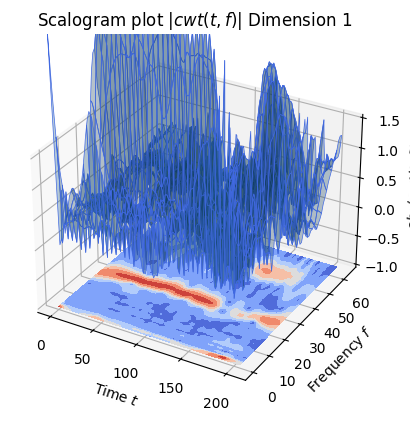

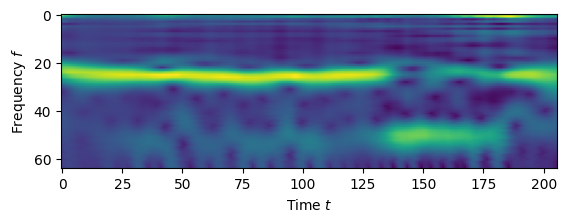

In [10]:
plot_3d_scalogram(X_train[0][1],dim=1)
plot_2d_scalogram(X_train[0][1],dim=1)

### Dimension-Patch-Wise Embedding (DPW)
Before we use attention on the inputs, we create smaller patches along the time and frequency axis. There are two main reason for that, as statet by the [Crossformer](https://openreview.net/forum?id=vSVLM2j9eie) [Yunhao Zhang 2023] paper.
 - A single value at a step alone provides little information
 - Attention values have a tendency to segment, i.e. close data points have similar attention weights

Futhermore it allows us to reduce the number of weights in the attention mechanism and is also often used by other transformer classification networks [Multi-Channel Vision Transformer for Epileptic
Seizure Prediction](https://pubmed.ncbi.nlm.nih.gov/35884859/) [Hussein et al., 2022], [PatchTST](https://arxiv.org/abs/2211.14730) [Nie et al., 2023] and [Crossformer](https://openreview.net/forum?id=vSVLM2j9eie) [Yunhao Zhang 2023] </br>

One can think of patching as slicing the scalogram into smaller arrays. The following figure shows the whole process including the Wavelet transformation<br>
<img src="src/figures/dpw.png" width="350"><br>
In Mathematical terms the patching can be described as followed: </br>
$X_{1:T,1:F}=\{y_{d,i,j}|0\leq d< D,0\leq i < \frac{T}{S_{T}},0\leq j < \frac{F}{S_{F}}\}$ <br/>
$x_{d,i,j}=\{x_{scal| d,t,f}|i\times S_{T}\leq t <(i+1)\times S_{T},j\times S_{F}\leq f <(j+1)\times S_{F}\}$<br/>
$S_t$ and $S_F$ is <code>size_F</code> resp. <code>size_t</code> in the code and represent the patch size.<br/>

In order to further reduce the amount of parameters, we use a linear projection to reduce the patch size. To embed the positional information in time, frequency and dimension we add a learnable position value on top each patch<br>
$y_{d,i,j}=H^{(proj)}x_{i,j,d}+H_{d,i,j}^{(pos)}$ <br/>
Where $H_{d,i,j}^{(pos)} \in \mathbb{R}^{D \times \frac{T}{S_{T}} \times \frac{F}{S_{F}} \times d_{model}}$ is the positional embedding and $H^{(proj)}\in \mathbb{R}^{S_T \times S_F \times D_model}$ is the learnable projection. In addition we pad with $0$ so the frequency and time dimension is a multiple of 2 which makes the concating layers faster.


In [11]:
def ceil_to_b(a,b):
    return -1 * (-a // pow(2,b))

class DimensionPatchWiseEmbedding(tf.keras.layers.Layer):
  def __init__(self, size_T=10,size_F=4,d_model=20,levels=3):
    super().__init__()
    self.size_T = size_T
    self.size_F = size_F
    self.levels=levels
    self.d_model = d_model

  def build(self, input_shape):
    # learnable projection weights
    self.w = self.add_weight("projection_weights",shape=(self.d_model,self.size_T*self.size_F), initializer="random_normal", trainable=True)
    # learnable position weights
    b_shape = (input_shape[1],)+(int(np.ceil(input_shape[2]/self.size_T)),int(np.ceil(input_shape[3]/self.size_F)),self.d_model)
    self.b = self.add_weight("positional_weights",shape=b_shape, initializer="random_normal", trainable=True)

  def call(self, x):
    patched_x  = []
    for obs in tf.split(x, num_or_size_splits=int(x.shape[1]), axis=1):
      obs=tf.transpose(obs,[0,2,3,1])
      # extract the patches from the scalogram
      patches = tf.image.extract_patches(images=obs,
                                        sizes=[1, self.size_T, self.size_F, 1],
                                        strides=[1, self.size_T, self.size_F, 1],
                                        rates=[1, 1, 1, 1],
                                        padding='SAME') # Notice "SAME" means the patchs will be padded with zeros. Use "VALID" for no padding.
      patched_x.append(patches)
      # Stack up all observations in a batch
    patched_x=tf.stack(patched_x, axis=1)
    # Make the linear projection and add the positional embedding
    patched_x=tf.expand_dims(patched_x, 5)
    # Project an add positional embedding
    patched_x= tf.squeeze(tf.matmul(self.w,patched_x))+self.b
    # Pad to multiple of 2
    new_f=int(ceil_to_b(tf.shape(patched_x)[3],self.levels)*pow(2,self.levels)-tf.shape(patched_x)[3])
    new_t=int(ceil_to_b(tf.shape(patched_x)[2],self.levels)*pow(2,self.levels)-tf.shape(patched_x)[2])
    paddings = tf.convert_to_tensor([[0, 0], [0, 0],[0, new_t],[0, new_f],[0, 0]])
    return tf.pad(patched_x, paddings, "CONSTANT"), tf.pad(tf.ones(tf.shape(patched_x)), paddings, "CONSTANT")

  def plot_weights(self,dim=[0]):
    fig, ax = plt.subplots()
    ax.set_title("$H^{(proj)}$ Learnable Projection Weights at Dimension "+str(dim))
    ax.set_xlabel("$d_{Patch}=S_{T}\cdot S_{F}$")
    ax.set_ylabel("$d_{Model}$")
    im = ax.imshow(self.w)
    fig.colorbar(im,shrink=0.5) 

    fig2, ax2 = plt.subplots()
    ax2.set_title("$H^{(pos)}_{d,i,j}$ Learnable Position Weights at Dimension "+str(dim))
    ax2.set_xlabel("Time segment $i$")
    ax2.set_ylabel("Frequency segment $j$")
    im2 = ax2.imshow(np.asarray(self.b)[0][:][:][0])
    fig.colorbar(im2) 
    plt.show()

let us test the Dimension-Patch-Wise Embedding. The first plot shows projection mask $H^{(proj)}$ which is the same for each patch and reduces its size from $d_{Patch}=S_{T}\cdot S_{F}$ (flattened representation of patch) to the desired length $d_{model}$.The $d_{model}$ in this architecture represents the same as in the original tranformer paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762), where the $d_{model}$ corresponds to the word embedding. The second plot is the positional embedding $H_{d,i,j}^{(pos)}$ at a specific dimesion, which only shows the initialized values at since the model has not been trained so far.

Scalogram shape: (5, 3, 206, 64)
Padded Patches Shape: (5, 3, 24, 16, 20)
Padded Mask Shape: (5, 3, 24, 16, 20)


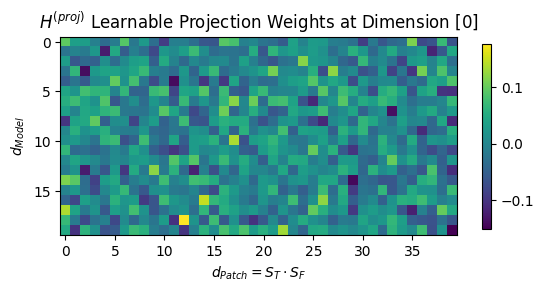

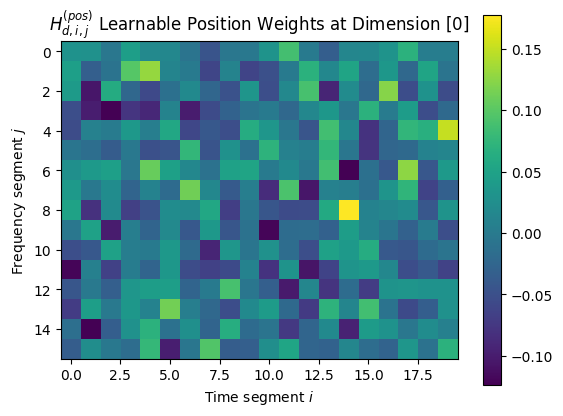

In [12]:
x_sample=X_train[:5]
print("Scalogram shape: {}".format(x_sample.shape))
patchingLayer=DimensionPatchWiseEmbedding()
x_patched,mask_sample=patchingLayer(x_sample)
print("Padded Patches Shape: {}".format(x_patched.shape))
print("Padded Mask Shape: {}".format(mask_sample.shape))
patchingLayer.plot_weights()


### Transformer Encoder
The transfomer encoder is based on the encoder used by the ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) paper. Key difference are:
 - The data has 2 additional axis, since there are 3 options (dimension:1, time:2, frequency:3). The Multi Head Attention (MHA) only pays attention on one of those axis.
 - During reconstruction the model randomly masks some of the top values he previously learned. When he is not reconstructing he only masks the padded values

$\hat{Z}^{freq}_{d,i,:} = \text{LayerNorm}(Z_{d,i,:}+\text{MHA}(Z_{d,i,:},Z_{d,i,:},Z_{d,i,:}))$<br>
$Z^{freq}= \text{LayerNorm}(\hat{Z}^{freq}+\text{MLP}(\hat{Z}^{freq}))$

In [13]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self,num_heads=4, dropout_rate=0.1,cross_direction="time"):
    super().__init__()
    self.num_heads=num_heads
    self.dropout_rate=dropout_rate
    self.cross_dir=cross_direction
    self.dir={"dimension":1,"time":2,"frequency":3}[cross_direction] # 1 Cross-Dimension, 2 Cross-Time, 3 Cross-Frequency

  def build(self, input_shape):   
    self.mha = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads,key_dim=int(np.ceil(input_shape[-1]/self.num_heads)),attention_axes=(self.dir),kernel_initializer="random_normal")
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.dense=tf.keras.layers.Dense(input_shape[-1],activation='relu')
    self.add = tf.keras.layers.Add()
    self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

  
  def call(self, x,mask,reconstructing,training):
    if(reconstructing == False):
       mask=tf.experimental.numpy.moveaxis(mask, self.dir, -2)
       mask=tf.reduce_max(mask, -1)
       self.mask=mask[:,:,:, tf.newaxis, tf.newaxis, :]
       y=x
    else:
      y=tf.cast(tf.expand_dims(self.series_mask,axis=-1),tf.float64) * tf.cast(x,tf.float64)
    attn_output, attn_scores = self.mha(
          query=x,
          key=x,
          value=x,
          attention_mask=self.mask,
          return_attention_scores=True)
      # Cache the attention scores for plotting later.
    self.last_attn_scores=attn_scores
    x = self.add([y, attn_output])
    x = self.layernorm(x)
    x = self.dropout(x,training)
    x = self.add([x, self.dense(x)])
    x = self.layernorm(x)
    return x

  def plot_attention_matrix(self,mask):
    fig, ax = plt.subplots()
    mask=tf.experimental.numpy.moveaxis(mask, self.dir, -2)
    mask=tf.reduce_max(mask, -1)
    mask=int(tf.reduce_sum(mask[0][0][0], -1))
    im = ax.imshow(self.last_attn_scores[0][0][0][0][:mask,:mask])
    fig.colorbar(im) 
    ax.set_title("$M=Q\cdot K^T$ Masked Multi Head Attention Mask (cross-{})".format(self.cross_dir))
    ax.set_xlabel("Input $i\in L_{{}}$".format(self.cross_dir))
    ax.set_ylabel("Output $i\in L_{{}}$".format(self.cross_dir))
    plt.show()
  

  def attention_graph(self,show_factor=0.9):
    mask = np.asarray(self.last_attn_scores[0][0][0][0])
    condlist = [mask<np.quantile(mask,show_factor)]
    choicelist = [0]
    matrix = np.select(condlist, choicelist, 1)
    G2 = nx.from_numpy_array(matrix)
    to_be_removed = [x for  x in G2.nodes() if G2.degree(x) <= 1]
    for x in to_be_removed:
        G2.remove_node(x)
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.set_title('Attention Score as Graph')
    nx.draw_circular(G2,with_labels=True,node_color='r')
    _ = ax.axis('off')
    plt.axis('equal')

  def get_tss_mask(self,mask_ratio=0.2,top_ratio=0.1):
    mask = self.last_attn_scores
    top_quantil=np.quantile(mask,1-top_ratio)
    condlist = [mask>=top_quantil, mask>0]
    choicelist = [2,1]
    mask = np.select(condlist, choicelist, 0)
    unique, counts = np.unique(mask, return_counts=True)
    count=dict(zip(unique, counts))
    mask[mask==2]=np.random.randint(1,100,count[2])
    mask[mask>=100*(1-mask_ratio)]=0
    mask[mask>0]=1
    self.mask=mask

    self.series_mask=np.array(tf.reduce_sum(tf.reduce_sum(mask, -1),-2))
    lowest=np.quantile(self.series_mask,top_ratio)
    self.series_mask[self.series_mask<lowest]=0
    self.series_mask[self.series_mask>0]=1
    self.series_mask = tf.experimental.numpy.moveaxis(self.series_mask, -1, self.dir)
    return mask

The following two heatmaps show the attention score, where the x and y axis represent the number of patches along the time domain $L_t$ with their corresponing attention. Due to the sofmax function the rows sum up to 1. The second heatmap shows us the same attention scores but with a few top values masked. The model will finally train once on the classification problem and then once on the reconstruction problem where some values are masked so that it learns valuable information from the original signal which should improve the classification and prevent overfitting.

(5, 3, 24, 16, 20)


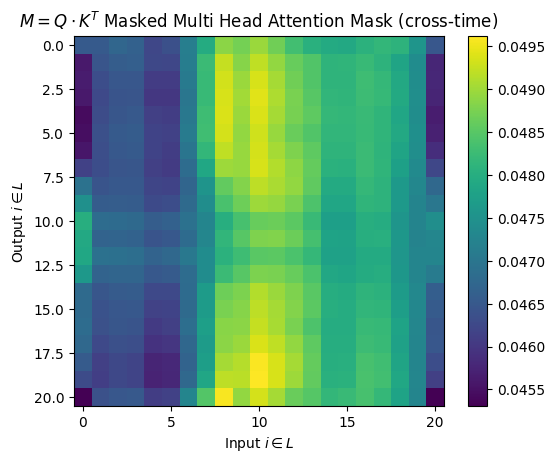

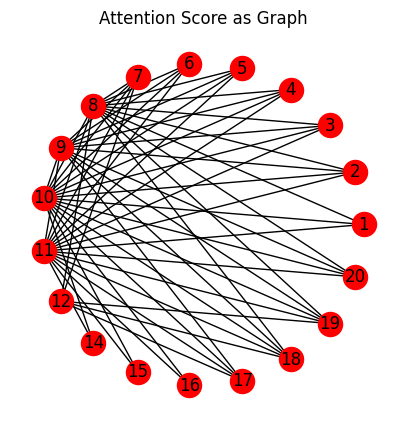

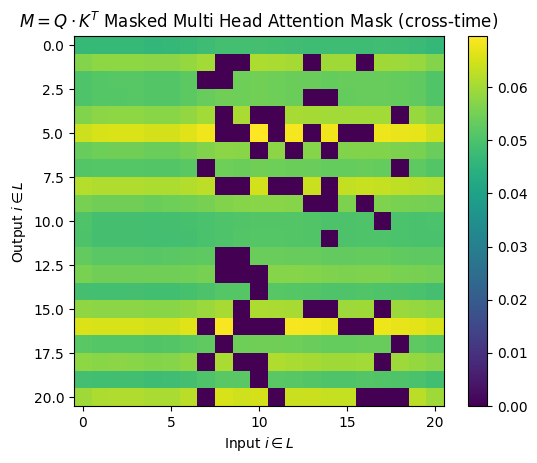

In [14]:
sample_transformer_encoder = TransformerEncoder(cross_direction="time")
x_time=sample_transformer_encoder(x_patched,mask_sample,False,False)
print(x_time.shape)
sample_transformer_encoder.plot_attention_matrix(mask_sample)

# plot it again but mask radmoly from top n values
sample_transformer_encoder.get_tss_mask(0.2,0.1)
sample_transformer_encoder.attention_graph()
x_time=sample_transformer_encoder(x_patched,mask_sample,True,False)
sample_transformer_encoder.plot_attention_matrix(mask_sample)


### Three-Stage Attention
In order to capture cross-dependencies, three stage attention is proposed. We try to capture dependencies between patches by stacking up 3 transformer encoder on top of each other, where each pays attention to another axis. The architecture is quite similar to the one proposed by the [Crossformer](https://openreview.net/forum?id=vSVLM2j9eie) [Yunhao Zhang 2023] paper. But there is an adittional axis for the frequency domain.<br>
<img src="src/figures/tsa.png" width="350"><br>


In [15]:
class ThreeStageAttention(tf.keras.layers.Layer):
  def __init__(self,num_heads,dropout_rate,mask_ratio=0.2,top_ratio=0.1):
    super().__init__()
    self.dim_ca = TransformerEncoder(num_heads,dropout_rate,cross_direction="dimension")
    self.time_ca = TransformerEncoder(num_heads,dropout_rate,cross_direction="time")
    self.freq_ca = TransformerEncoder(num_heads,dropout_rate,cross_direction="frequency")
    self.mask_ratio=mask_ratio
    self.top_ratio=top_ratio

  def call(self,x,mask,reconstructing,training):
    if(reconstructing):
      self.time_ca.get_tss_mask(self.mask_ratio,self.top_ratio)
      self.freq_ca.get_tss_mask(self.mask_ratio,self.top_ratio)
      self.dim_ca.get_tss_mask(self.mask_ratio,self.top_ratio)

    x=self.time_ca(x,mask,reconstructing,training)
    x=self.freq_ca(x,mask,reconstructing,training)
    x=self.dim_ca(x,mask,reconstructing,training)
    return x
  
  def visualize(self,mask):
    self.time_ca.plot_attention_matrix(mask)
    self.time_ca.attention_graph()


### DownScale
The downscale layer allows us to create hierarchical structures which is necessary to capture information at different scales. The layer merges four patches into one by linearly projecting them with a projection matrix $H\in \mathbb{R}^{4D_{model}\times D_{model}}$.<br>
$Z^{concat}=H \begin{bmatrix} Z_{d,2i,2j} & Z_{d,2i+1,2j+1}\\Z_{d,2i+i,2j} & Z_{d,2i+1,2j+1}  \end{bmatrix}, 0\leq d<D,0\leq i <\frac{L_T}{2},0\leq j <\frac{L_F}{2}$ 


In [16]:
class DownScale(tf.keras.layers.Layer):
  def __init__(self,d_model):
    super().__init__()
    self.d_model=d_model
    self.w = self.add_weight("downscale_projection",shape=(self.d_model*4,self.d_model), initializer="random_normal", trainable=True)


  def call(self, x,mask):
    concat_shape=[tf.shape(x)[0],tf.shape(x)[1],tf.shape(x)[2]//2,tf.shape(x)[3]//2,tf.shape(x)[4]*4]
    mask_shape=[tf.shape(x)[0],tf.shape(x)[1],tf.shape(x)[2]//2,tf.shape(x)[3]//2,tf.shape(x)[4],4]
    x=tf.reshape(x,concat_shape)
    mask=tf.reshape(mask,mask_shape)
    mask=tf.reduce_max(mask, -1)
    return tf.matmul(x,self.w),mask

print("Before Concat: {}".format(x_time.shape))
print("Before Concat Mask Shape: {}".format(mask_sample.shape))
sample_concat = DownScale(tf.shape(x_time)[-1])
x_concated,sample_concat_mask=sample_concat(x_time,mask_sample)
print("After Concat: {}".format(x_concated.shape))
print("After Concat Mask Shape: {}".format(x_concated.shape))





Before Concat: (5, 3, 24, 16, 20)
Before Concat Mask Shape: (5, 3, 24, 16, 20)
After Concat: (5, 3, 12, 8, 20)
After Concat Mask Shape: (5, 3, 12, 8, 20)


### Fully Connected for Classification
The fully connected layer are two dense layer which map the results from the attenion mechanisme to the one hot encoded labels.

In [17]:
# Fully Connected for Classification
class FullyConnectedClassification(tf.keras.layers.Layer):
  def __init__(self, output_size=5, dff=256, dropout_rate=0.1,num_tsa=3,dim=3):
    super().__init__()
    self.denseReLu1=[]
    self.dim=dim
    for i in range(num_tsa):
      self.denseReLu1.append(tf.keras.layers.Dense(20, activation='relu'))
    self.denseReLu2 = tf.keras.layers.Dense(dff, activation='relu')
    self.denseReLu3 = tf.keras.layers.Dense(dff, activation='relu')
    self.dropout =  tf.keras.layers.Dropout(dropout_rate)
    self.denseSig =  tf.keras.layers.Dense(output_size,activation='sigmoid')
    self.softmax = tf.keras.layers.Softmax()
    self.flatten=tf.keras.layers.Flatten()


  def call(self, x,training=False):
    result=[]
    for ind,z in enumerate(x):
        z=tf.transpose(z, perm=[0,1,3,4,2])
        #z=tf.reshape(z,[tf.shape(z)[0],tf.shape(z)[1],tf.shape(z)[2],tf.shape(z)[3]*tf.shape(z)[4]])
        result.append(self.flatten(self.denseReLu1[ind](z)))
    x = tf.concat(result,axis=1)
    x = self.dropout(x,training)
    x = self.denseReLu2(x)
    x = self.denseReLu3(x)
    x = self.denseSig(x)
    return self.softmax(x)

### Fully Connected for Reconstruction
This layer does more or less the same as the previous one, but maps them to the models input, since the aim is to reconstruct those values from the Task Specific Selection (TSS) masked attention mechanisme.

In [18]:
class FullyConnectedReconstruction(tf.keras.layers.Layer):
  def __init__(self, output_size=5, recon_dff=1024, dropout_rate=0.1,num_tsa=3,dim=3):
    super().__init__()
    self.denseReLu1=[]
    self.dim=dim
    for i in range(num_tsa):
      self.denseReLu1.append(tf.keras.layers.Dense(20, activation='relu'))
    self.dropout =  tf.keras.layers.Dropout(dropout_rate)
    self.denseReLu2 =  tf.keras.layers.Dense(recon_dff,activation='relu')
    self.denseReLu3 =  tf.keras.layers.Dense(recon_dff,activation='relu')
    self.denseReLu4 =  tf.keras.layers.Dense(output_size)

    self.flatten=tf.keras.layers.Flatten()

  def call(self, x,shape,training=False):
    result=[]
    for ind,z in enumerate(x):
        z=tf.transpose(z, perm=[0,1,3,4,2])
        #z=tf.reshape(z,[tf.shape(z)[0],tf.shape(z)[1],tf.shape(z)[2],tf.shape(z)[3]*tf.shape(z)[4]])
        result.append(self.flatten(self.denseReLu1[ind](z)))
    x = tf.concat(result,axis=1)
    x = self.dropout(x,training)
    x = self.denseReLu2(x)
    x = self.denseReLu3(x)
    x = self.denseReLu4(x)
    x = tf.reshape(x,[x.shape[0]]+shape)
    return x


## Classformer
The Model starts with the Wavelet trasformation on the time-series. Afterwards the values get patched and go through the hirarchical TSA stack. The result of each TSA gets concatenated and flattened and gets classified by a fully connected layer. Te reconstruction model uses the same architecture but has a differen fullyconnected layer similar to the architecture proposed by the [TARNet](https://dl.acm.org/doi/10.1145/3534678.3539329) paper.
<br>

<img src="src/figures/model.png" width="500"><br>


In [19]:
class Classformer(tf.keras.Model):
  def __init__(self,output_size,recon_size,d_model,num_heads,dropout_rate,dff,recon_dff,num_tsa,size_T,size_F,mask_ratio,top_ratio):
    super().__init__()
    self.batchnorm = tf.keras.layers.BatchNormalization()
    self.patching = DimensionPatchWiseEmbedding(size_T=size_T,size_F=size_F,d_model=d_model,levels=num_tsa)
    self.num_tsa=num_tsa
    self.tsa=[]
    self.downscale=[]
    for encod in range(self.num_tsa-1):
      self.downscale.append(DownScale(d_model))
      self.tsa.append(ThreeStageAttention(num_heads,dropout_rate,mask_ratio,top_ratio))
    self.tsa.append(ThreeStageAttention(num_heads,dropout_rate,mask_ratio,top_ratio))
    self.fulldenseclass=FullyConnectedClassification(output_size=output_size, dff=dff, dropout_rate=dropout_rate,num_tsa=num_tsa,dim=recon_size[0])
    self.fulldensereconst=FullyConnectedReconstruction(output_size=np.prod(recon_size), recon_dff=recon_dff, dropout_rate=dropout_rate,num_tsa=num_tsa,dim=recon_size[0])
    self.recon_size=recon_size

  def call(self, inputs,reconstructing=False, training=False):

    # Normalize the Scalograms
    x=self.batchnorm(inputs)

    # Dimension Patch Wise Embedding
    z,mask = self.patching(x)
    self.original_mask=mask

    # Hierarchical TSA Stack
    result=[]
    for level in range(self.num_tsa-1):
      z=self.tsa[level](z,mask,reconstructing,training)
      result.append(z)
      z,mask=self.downscale[level](z,mask)
    z=self.tsa[self.num_tsa-1](z,mask,reconstructing,training)
    result.append(z)

    #Fully Connected Layer which map the result to reconstruction or classification
    if(reconstructing):
      self.fulldenseclass.trainable = False
      self.fulldensereconst.trainable = True 
      result=self.fulldensereconst(result,self.recon_size, training)
    else:
      self.fulldensereconst.trainable = False
      self.fulldenseclass.trainable = True
      result=self.fulldenseclass(result, training)
    return result
  
  def visualize(self):
    self.patching.plot_weights()
    self.tsa[0].visualize(self.original_mask)
  

### Hyperparameters

In [20]:
d_model=20
num_heads=4
dropout_rate=0.1
dff=256
recon_dff=256
num_tsa=3
size_T=10
size_F=4
mask_ratio=0.2
top_ratio=0.1
batch_size=15
epochs=50

In [21]:
scal=[]
lenT=tf.cast(np.ceil(tf.shape(X_train)[2]/10),dtype=tf.int64)
pool_2d = tf.keras.layers.AveragePooling2D(pool_size=(lenT, 4), strides=(lenT, 4), padding='valid')
for x_temp in tf.unstack(X_train,axis=1):
    scal.append(tf.squeeze(pool_2d(tf.expand_dims(x_temp,axis=-1))))
scal=tf.stack(scal,axis=1)

train_dataset = (X_train,labels_train,scal)
test_dataset = (X_test,labels_test)

### Inference
Try the the model

In [22]:
model=Classformer(output_size=len(meta_data["class_values"]),
              recon_size=scal.shape[1:],
              d_model=d_model,
              num_heads=num_heads,
              dropout_rate=dropout_rate,
              dff=dff,
              recon_dff=recon_dff,
              num_tsa=num_tsa,
              size_T=size_T,
              size_F=size_F,
              mask_ratio=mask_ratio,
              top_ratio=top_ratio)

print("Input Shape: {}".format(X_train[:5].shape))
output = model(X_train[:5],reconstructing=False, training=False)
output = model(X_train[:5],reconstructing=True, training=False)

print("Output Shape: {}".format(output.shape))
model.summary()


Input Shape: (5, 3, 206, 64)


Output Shape: (5, 3, 9, 16)
Model: "classformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 dimension_patch_wise_embed  multiple                  20960     
 ding_1 (DimensionPatchWise                                      
 Embedding)                                                      
                                                                 
 three_stage_attention (Thr  multiple                  6420      
 eeStageAttention)                                               
                                                                 
 three_stage_attention_1 (T  multiple                  6420      
 hreeStageAttention)                                             
                           

## Training

### Set up the optimizer
Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer paper.

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=5,steepness=1):
    super().__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps
    self.steepness=steepness

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)*((0.8**(step-self.warmup_steps))**self.steepness)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)*1e-02


In [37]:
recon_rate = CustomSchedule(d_model,10,0.12)
class_rate = CustomSchedule(d_model,10,0)


class_optimizer = tf.keras.optimizers.Adam(class_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
reco_optimizer = tf.keras.optimizers.Adam(recon_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

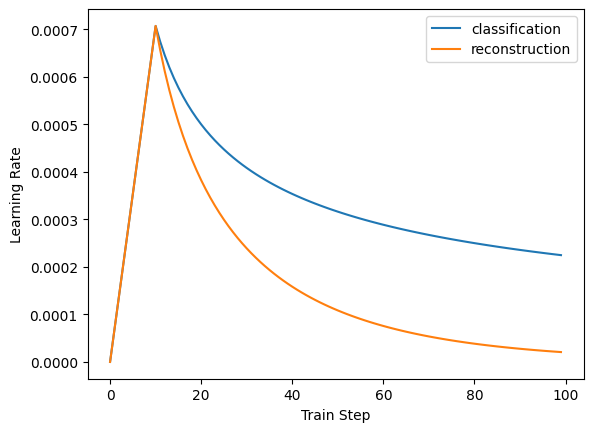

In [38]:
plt.plot(class_rate(tf.range(100, dtype=tf.float32)),label="classification")
plt.plot(recon_rate(tf.range(100, dtype=tf.float32)),label="reconstruction")
plt.legend()
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

Define a custom loss and gradients function

In [26]:
def loss(model, x, y, training,reconstructing):
  class_loss_object = tf.keras.losses.CategoricalCrossentropy()
  reco_loss_object=tf.keras.losses.MeanSquaredError()
  y_ = model(x, reconstructing=reconstructing,training=training)
  if(reconstructing):
    return reco_loss_object(y_true=y, y_pred=y_)
  else:
    return class_loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets, reconstructing):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, reconstructing=reconstructing, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

print("Classification")
loss_value, grads = grad(model, X_train[:5], labels_train[:5],reconstructing=False)
print("Step: {}, Initial Loss: {:.3f}".format(class_optimizer.iterations.numpy(),loss_value.numpy()))
class_optimizer.apply_gradients(zip(grads, model.trainable_variables))
print("Step: {},         Loss: {:.3f}".format(class_optimizer.iterations.numpy(), loss(model, X_train[:5], labels_train[:5],reconstructing=False, training=True).numpy()))

print("Reconstruction")
loss_value, grads = grad(model, X_train[:5], scal[:5],reconstructing=True)
print("Step: {}, Initial Loss: {:.3f}".format(reco_optimizer.iterations.numpy(),loss_value.numpy()))
reco_optimizer.apply_gradients(zip(grads, model.trainable_variables))
print("Step: {},         Loss: {:.3f}".format(reco_optimizer.iterations.numpy(), loss(model, X_train[:5], scal[:5],reconstructing=True, training=True).numpy()))



Classification
Step: 0, Initial Loss: 1.273
Step: 1,         Loss: 1.329
Reconstruction
Step: 0, Initial Loss: 1.073


KeyboardInterrupt: 

### Custom train loop
Two functions to nicely plot the epochs results

In [ ]:
def pretty_time_delta(seconds):
    seconds = int(seconds)
    days, seconds = divmod(seconds, 86400)
    hours, seconds = divmod(seconds, 3600)
    minutes, seconds = divmod(seconds, 60)
    if days > 0:
        return '%dd%dh%dm%ds' % (days, hours, minutes, seconds)
    elif hours > 0:
        return '%dh%dm%ds' % (hours, minutes, seconds)
    elif minutes > 0:
        return '%dm%ds' % (minutes, seconds)
    else:
        return '%ds' % (seconds,)
    
def pretty_metrics(values,names):
    out=""
    for i,val in enumerate(values):
        pre=""
        if(i//len(names)==1):
            pre="val_"
        out+=" - "+pre+names[i%len(names)]+": %.3f" % val
    return str(out)

In [ ]:
class_metrics = {"train":
                  {"accuracy":tf.keras.metrics.CategoricalAccuracy(),
                "auc":tf.keras.metrics.AUC()},
                "val":
                  {"accuracy":tf.keras.metrics.CategoricalAccuracy(),
                "auc":tf.keras.metrics.AUC()},
                "test":
                  {"accuracy":tf.keras.metrics.CategoricalAccuracy(),
                "auc":tf.keras.metrics.AUC()}
                }
reco_metrics = {"train":
                {"mse": tf.keras.metrics.MeanSquaredError()},
                "val":
                {"mse": tf.keras.metrics.MeanSquaredError()},
                "test":
                {"mse": tf.keras.metrics.MeanSquaredError()} 
                }

def test_inference(model,class_metrics,test_dataset):
  for (x, y) in test_dataset:
    y_pred = model(x,reconstructing=False, training=False)
    for metric in class_metrics["test"].values():
      metric.update_state(y,y_pred)
  temp_metric=[]
  for metric in class_metrics["test"].values():
    temp_metric.append(float(metric.result()))
  return temp_metric

# Training
def training(reconstructing_mode,
            model,
            class_optimizer,
            reco_optimizer,
            train_dataset,
            batch_size,
            test_dataset,
            class_metrics,
            reco_metrics,
            num_epochs,
            patience,
            num_folds):
  
  history={"train":[],"val":[],"test":[]}
  max_val_accuracy=0
  early_stopping_count=0

  # shuffle the train data
  indices = tf.range(start=0, limit=tf.shape(train_dataset[0])[0], dtype=tf.int32)
  idx = tf.random.shuffle(indices)
  x_full,y_full,cwtm_full = (tf.gather(train_dataset[0], idx),tf.gather(train_dataset[1], idx),tf.gather(train_dataset[2], idx))
  test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
  test_dataset = test_dataset.batch(batch_size)

  for epoch in range(num_epochs):
    start = time.time()

    # split the dataset in val and train
    fold=epoch%num_folds
    shift=tf.cast(tf.shape(x_full)[0]/num_folds,dtype=tf.int64)
    x_roll,y_roll,cwtm_roll = tf.roll(x_full,shift=shift*fold,axis=0),tf.roll(y_full,shift=shift*fold,axis=0),tf.roll(cwtm_full,shift=shift*fold,axis=0)
    x_val,x_train=(x_roll[-shift:],x_roll[:-shift])
    y_val,y_train=(y_roll[-shift:],y_roll[:-shift])
    cwtm_val,cwtm_train=(cwtm_roll[-shift:],cwtm_roll[:-shift])

    val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val,cwtm_val))
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train,cwtm_train))
    train_dataset = train_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    # Training loop - using batches of ...
    for (x, y, cwtm) in train_dataset:
      # Optimize the model with Classification
      loss_value, grads = grad(model, x, y,reconstructing=False)
      class_optimizer.apply_gradients(zip(grads, model.trainable_variables))
      y_pred=model(x,reconstructing=False, training=True)
      for metric in class_metrics["train"].values():
        metric.update_state(y,y_pred)

      if(reconstructing_mode):
        # Optimize the model with Reconstruction
        loss_value, grads = grad(model, x, cwtm,reconstructing=True)
        reco_optimizer.apply_gradients(zip(grads, model.trainable_variables))
        y_pred=model(x,reconstructing=True, training=True)
        for metric in reco_metrics["train"].values():
          metric.update_state(cwtm,y_pred)


    # Validation
    for (x, y,cwtm) in val_dataset:
      y_pred = model(x,reconstructing=False, training=False)
      for metric in class_metrics["val"].values():
        metric.update_state(y,y_pred)

      if(reconstructing_mode):
        y_pred = model(x,reconstructing=True, training=False)
        for metric in reco_metrics["val"].values():
          metric.update_state(cwtm,y_pred)

    # End epoch
    temp_metric=[]
    for metric in class_metrics["train"].values():
        temp_metric.append(float(metric.result()))
    for metric in reco_metrics["train"].values():
        temp_metric.append(float(metric.result()))
    history["train"].append(temp_metric)
    temp_metric=[]
    for metric in class_metrics["val"].values():
        temp_metric.append(float(metric.result()))
    for metric in reco_metrics["val"].values():
        temp_metric.append(float(metric.result()))
    history["val"].append(temp_metric)

    if(max_val_accuracy>=temp_metric[0]):
      save_model=True
      early_stopping_count+=1
    else:
      max_val_accuracy=temp_metric[0]
      early_stopping_count=0

    time_elapsed = (time.time() - start)
    print("Epoch {:03d} - {} - train accuracy: {:.3f} - train mse: {:.3f} - val accuracy: {:.3f} - val mse: {:.3f}".format(epoch,
                                                                                                                                 str(pretty_time_delta(time_elapsed)),
                                                                                                                                 history["train"][-1][0],
                                                                                                                                 history["train"][-1][-1],
                                                                                                                                 history["val"][-1][0],
                                                                                                                                 history["val"][-1][-1]))
    if(early_stopping_count>=patience):
      history["test"].append(test_inference(model,class_metrics,test_dataset))
      return history
  history["test"].append(test_inference(model,class_metrics,test_dataset))
  return history



In [ ]:
history = training(reconstructing_mode=True,
            model=model,
            class_optimizer=class_optimizer,
            reco_optimizer=reco_optimizer,
            train_dataset=train_dataset,
            batch_size=batch_size,
            test_dataset=test_dataset,
            class_metrics=class_metrics,
            reco_metrics=reco_metrics,
            num_epochs=epochs,
            patience=3,
            num_folds=10)
history["train"] = np.transpose(np.array(history["train"]))
history["val"] = np.transpose(np.array(history["val"]))

Epoch 000 - 21s - train accuracy: 0.298 - train mse: 0.801 - val accuracy: 0.692 - val mse: 0.682
Epoch 001 - 21s - train accuracy: 0.573 - train mse: 0.707 - val accuracy: 0.692 - val mse: 0.608
Epoch 002 - 21s - train accuracy: 0.691 - train mse: 0.652 - val accuracy: 0.744 - val mse: 0.593
Epoch 003 - 21s - train accuracy: 0.766 - train mse: 0.617 - val accuracy: 0.769 - val mse: 0.570
Epoch 004 - 21s - train accuracy: 0.813 - train mse: 0.593 - val accuracy: 0.815 - val mse: 0.546
Epoch 005 - 21s - train accuracy: 0.844 - train mse: 0.575 - val accuracy: 0.846 - val mse: 0.521
Epoch 006 - 21s - train accuracy: 0.866 - train mse: 0.560 - val accuracy: 0.868 - val mse: 0.515
Epoch 007 - 21s - train accuracy: 0.883 - train mse: 0.547 - val accuracy: 0.885 - val mse: 0.508
Epoch 008 - 21s - train accuracy: 0.896 - train mse: 0.536 - val accuracy: 0.897 - val mse: 0.507
Epoch 009 - 21s - train accuracy: 0.906 - train mse: 0.528 - val accuracy: 0.908 - val mse: 0.497
Epoch 010 - 21s - tr

(3, 50)


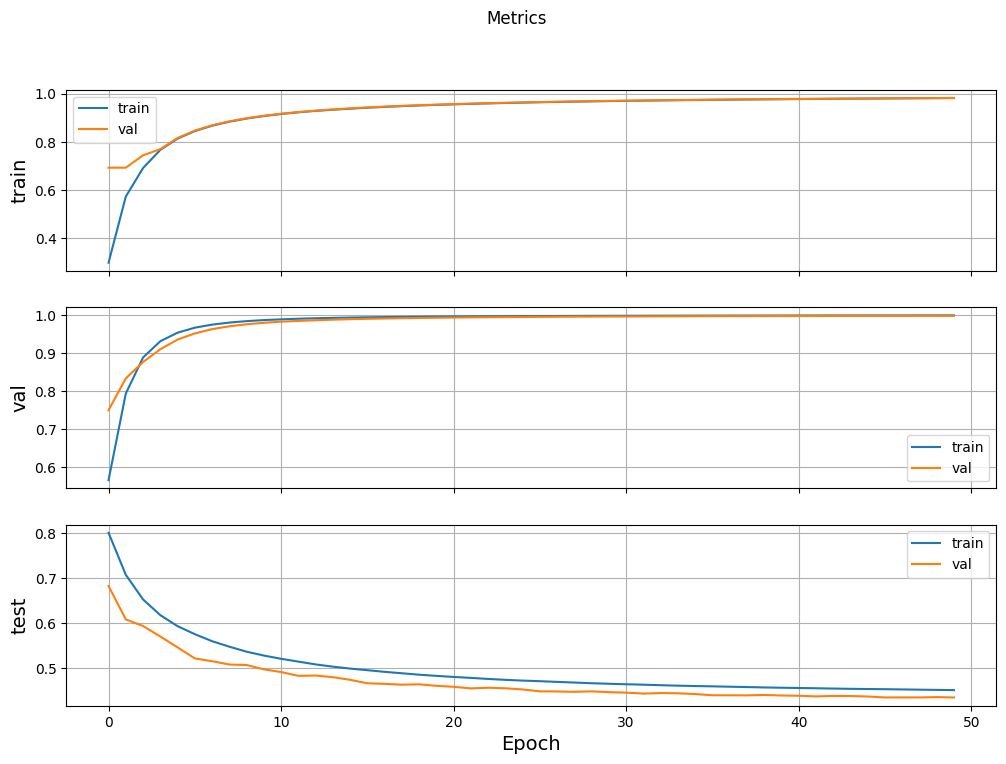

[[0.9855072498321533, 0.9998512268066406]]


In [ ]:
print(history["val"].shape)
def plot_history(history,metrics):
    fig, axes = plt.subplots(len(metrics), sharex=True, figsize=(12, 8))
    fig.suptitle('Metrics')

    for ind,key in enumerate(metrics):
        
        axes[ind].set_ylabel(key, fontsize=14)
        axes[ind].plot(history["train"][ind],label="train")
        axes[ind].plot(history["val"][ind],label="val")
        axes[ind].grid()
        axes[ind].legend()
        if ind==len(metrics)-1:
            axes[ind].set_xlabel("Epoch", fontsize=14)
    plt.show()

d4 = dict(class_metrics)
d4.update(reco_metrics)
plot_history(history,d4)
print(history["test"])

## Visualize Results

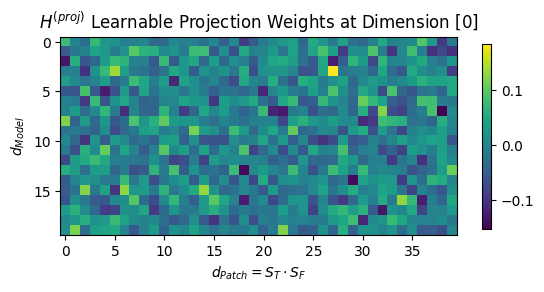

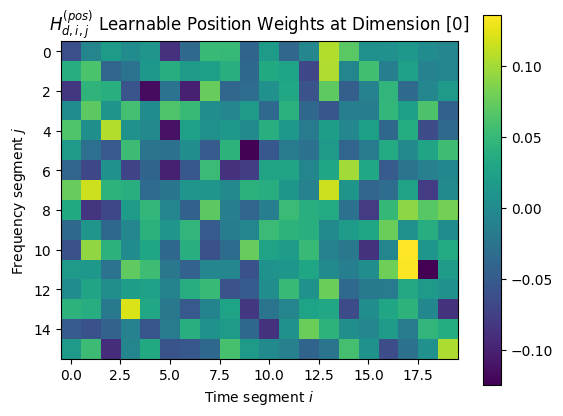

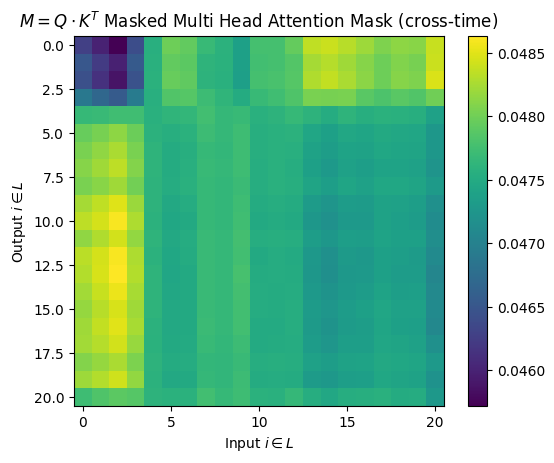

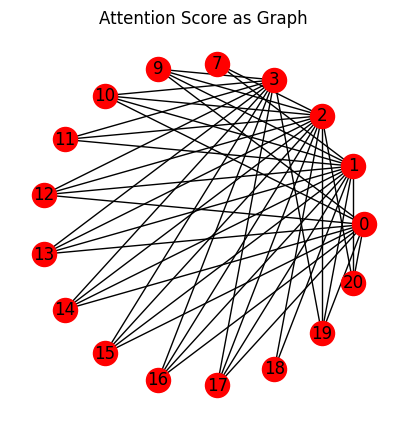

In [ ]:
model.visualize()

In [ ]:
output = model(X_train[:5],reconstructing=False, training=False)

## Conclusion
[tsml-eval](https://github.com/time-series-machine-learning/tsml-eval/tree/main)<br>
[result](https://timeseriesclassification.com/results/ReferenceResults/classification/accuracy/)